사용할 라이브러리들을 import

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
import datetime


### 

## data_setting 함수  
인자로 filename, start, end를 받는다.  
df = pd.read_csv(f'data/result/{filename}_result_0.4_16.7.csv',encoding='cp949')   
filename은 포맷팅을 이용하여 상대경로에 있는 전처리된 csv 파일을 데이터프레임으로 불러온다.  
  

df['reg_date'] = pd.to_datetime(df['reg_date'],format="%Y-%m-%d")
df=df.set_index(df['reg_date'])
해당 데이터 프레임의 index를 datetime 형태로 사용.

start와 end는 포맷팅을 이용하여 딥러닝 학습의 시작기간과 끝 기간을 설정하는데 사용된다.

In [2]:
def data_setting(filename, start, end): #종류 이름(salmon, shirimp, squid), 학습데이터 시작날짜, 학습데이터 종료날짜
    df = pd.read_csv(f'data/result/{filename}_result_0.4_16.7.csv',encoding='cp949') 

    df = df.fillna(0) 
    df['reg_date'] = pd.to_datetime(df['reg_date'],format="%Y-%m-%d")
    df=df.set_index(df['reg_date'])

    dataset = df.loc[f"{start}":f"{end}"].reset_index(drop=True)

    use_col = dataset.columns[1:]

    dataset=dataset[use_col]
    dataset=dataset.values

    return dataset, use_col

## scaler 함수
딥러닝의 정확도를 올리기 위하여 sklearn에서 제공하는 MinMaxScaler를 사용한다. 나중에 예측한 값을 다시 역 정규화 해주기 위해서 scaler의 값을 sc로 같이 반환받아 둔다.

In [3]:
# 정규화 
def scaler(dataset):
    sc = MinMaxScaler(feature_range=(0,1))
    scaled_dataset = sc.fit_transform(dataset)
    return scaled_dataset, sc

## split_xy 함수
dataset, time_steps, y_column을 인자로 받는다.
dataset은 말 그대로 훈련하고자 하는 데이터셋이며, time_steps는 한 번 학습에 몇 행의 x데이터를 학습시킬것인가를, y_column은 한번에 몇 행의 y데이터를 학습시킬것인가를 의미한다. 즉 time_steps만큼의 행을 가진 x데이터가, y_column만큼의 행을 가진 y데이터와 매칭된다.   
이때 이 x데이터와 y데이터는 csv파일 내의 같은 열에 속하는 데이터들이며, 현재 x데이터로부터 time_steps 만큼 아래에 있는 데이터가 첫 y데이터가 되도록 구성되어 있다.

In [4]:
def split_xy(dataset, time_steps, y_column): #학습할 dataset, 한 번에 학습할 windowsize, 예측할 날짜 크기
    x=[]
    y=[]
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        
        tmp_x = dataset[i:x_end_number, :]
        tmp_y = dataset[x_end_number:y_end_number,:]
        
        x.append(tmp_x)
        y.append(tmp_y)

        x_array = np.array(x)
        y_array = np.array(y)
        
        y_shape = (y_array.shape[0],y_array.shape[1],y_array.shape[2])

        y_array = y_array.reshape(y_shape[0],y_shape[1]*y_shape[2])
        
    return x_array, y_array, y_shape


## load_models 함수
modelname을 인자로 받고, 받은 문자열과 같은 h5확장자를 가진 모델을 찾아 마운트한다.  
그리고 모델의 정보를 summary()를 통해 출력한다.

In [5]:
def load_models(modelname): # 모델 로드. 모델을 불러오려면 load_modeld을 해줍시다. 
    model = load_model(f"{modelname}.h5")
    model.summary()
    return model

## model_setting 함수
type과 unit을 인자로 받는다. type은 레이어에 사용될 RNN 함수의 종류이다. SimpleRNN, LSTM, GRU 등을 사용 할 수 있다.  
unit은 첫번째 레이어의 유닛의 수 이다.  
모델은 옵티마이저로 adam을, loss의 평가로는 mse를 사용한다.  
split_data 함수로 잘려 나올 x와 y의 크기를 이용해 인풋 크기와 아웃풋 크기를 가지므로 따로 편집해 줄 필요는 없다.

In [6]:
def model_setting(type,unit):
    model = Sequential()
    model.add(type(unit, input_shape=(x.shape[1],x.shape[2])))  # 활성화 함수 

    model.add(Dense(y.shape[1]))  
    model.summary()
    model.compile(optimizer='adam',loss='mse')
    return model


## model_train 함수
x_train, y_train, model, epoch, batchsize 를 인자로 받는다.  
x_train과 y_train은 모델로 학습될 x,y데이터를 의미한다.   model은 어떤 모델로 학습할지를 의미한다.   위에서 load된 모델이나 setting한 모델을 사용 할 수 있다.  
epoch는 훈련을 몇번 시행할것인지 epoch를 의미한다. batchsize역시 훈련에 사용될 batchsize를 의미한다.  
early_stopping을 지원하는데, loss의 min 즉 최소값을 기준으로 하여, loss의 최소값이 갱신되었을때, 10번의 훈련동안 추가로 loss가 감소하지 않는다면 훈련을 종료시킨다. 

In [7]:
def model_train(x_train,y_train,model,epoch,batchsize):
    early_stopping = EarlyStopping(monitor='loss',patience=10,mode='min')  #  
    model.fit(x_train,y_train,epochs=epoch,batch_size=batchsize, callbacks=[early_stopping])  # 벨리데이션 스플릿 
    return model

## predict 함수
model과 sc를 인자로 받는다.  
기본적으로 선택된 model로 예측을 하는데, 이때 학습의 마지막 window_size 즉 timesteps 만큼의 x데이터를 x_test라고 하며, 이 x_test로 y데이터를 예측한다.   즉 마지막 훈련으로부터 split_xy함수의 y_columns 크기만큼의 예측한 결과를 y_pred 변수에 담는다. 예측하기 위해서 차원의 변환이 들어있다.  
또한 sc는 위의 scaler함수에서 반환받았던 값으로, 예측된 값 역시 정규화가 되어있으므로 역 정규화를 위해 필요한 인자이다.  

In [8]:
def predict(model,sc):
    x_test = dataset[-window_size:] 
    x_test=x_test.reshape(1,x_test.shape[0],x_test.shape[1]) 
    y_pred = model.predict(x_test)  
    y_pred=y_pred.reshape(y_shape[1],y_shape[2])
    y_pred = sc.inverse_transform(y_pred)
    return y_pred


## ensemble 함수
ensemble 함수는 두 예측 결과를 앙상블하는데 사용된다.  
y_pred와 y_pred2는 각각 두 예측결과이며, a와 b는 a:b의 비율로 소프트 앙상블 하겠다 를 의미한다.

In [9]:
def ensemble(y_pred,y_pred2,a,b): #predict1, predict2, 앙상블하고자 하는 비율을 a:b로 적어주세요.(각각 1~9 사이)
    en=[]
    for i in range(len(y_pred)):
        en.append((y_pred[:,-1][i]*a*0.1+y_pred2[:,-1][i]*b*0.1))

    return en

## save_csv 함수
save_csv 함수는 data와 date를 인자로 받는다.  
data는 저장하고자 하는 예측된 데이터를 의미하며, date는 예측이 시작된 날짜를 입력해주면 된다.  
이 과제에서는 매주 월요일마다 정기적으로 수출이 이루어졌으므로, 입력된 날짜를 기준으로 데이터 수만큼 7일씩 늘려가며 index로 삼고
csv파일로 저장한다.   
이때 매번 제목을 바꾸기 위해 코드를 바꾸거나 해야할 불편을 덜고 또한 기억의 용이성을 돕기 위해 코드가 실행되어 저장되는 순간 파일명으로 현재 날짜와 시 분 초가 들어간다.

In [10]:
###save_csv(gra2,"2021-01-04") 와 같이 사용해주세요. 각각 결과와 기록하고자 하는 시작날짜가 들어가면 됩니다. (날짜 가능 형식: "YYYY-mm-dd")

def save_csv(data,date):
    datetime2=datetime.datetime.strptime(date, r'%Y-%m-%d')  
    datelist=[]
    df=pd.DataFrame(data)
    
    for i in range(len(df.index)):
        datetime3=datetime2.strftime(r'%Y-%m-%d')
        datelist.append(datetime3)
        datetime2=datetime2+datetime.timedelta(weeks=1)
    
    df.index=datelist
    df.columns=['p_price']
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    df.to_csv(f'{date}부터의 예측결과 {now}.csv',encoding='cp949')




## save_model 함수
save_model 함수는 model과 name을 인자로 받는다.  
해당되는 모델을 name.h5라는 파일로 저장한다.

In [11]:
def save_model(model,name):
    model.save(f'{name}.h5')
    print(f'{name}.h5 로 저장완료')


## 메인
dataset, use_col = data_setting('shrimp','2016-07','2020-12')  
해당 코드에서는 먼저 'shrimp','2016-07','2020-12'를 인자로 하는 data_setting 함수를 호출한다.  
즉 새우의 데이터를 2016년 7월부터 2020년 12월까지 학습시키기 위한 데이터 프레임을 얻을 수 있다.  

dataset, sc = scaler(dataset)  
dataset을 MinMaxScaler를 이용해 정규화 해준다.  

window_size = 52  
x, y, y_shape = split_xy(dataset, window_size, 26)  
timesteps는 52이며, y_columns가 26인 값을 갖는 split_xy 함수를 호출한다.  
즉 매 학습마다 52주의 정보를 학습하여, 이후 26주의 값을 학습하고 예측하는 모델을 만들기 위한 데이터 셋을 자르는 부분이다.  

model = model_setting(LSTM,16)  
model = model_train(x,y,model,250,16)  
model2 = model_setting(GRU,64)  
model2 = model_train(x,y,model2,250,64)  
첫번째 모델은 LSTM모델이며 unit이 16개인 모델이다.  
두번째 모델은 GRU모델이며 unit이 64개인 모델이다.  

#model = load_models('흰다리새우LSTM')  
#model2 = load_models('흰다리새우GRU')  
이번 코드에서는 사용되지 않지만, 주석처리를 풀게 된다면, 이미 저장된 해당 이름을 가진 모델을 마운트 할 수 있다.  

y_pred = predict(model,sc)  
model로 학습된 데이터의 마지막 데이터로 향후 y_columns 크기만큼 예측을 한다. 해당 코드에서는 26주를 예측한다.  
y_pred2 = predict(model2,sc)    
model2로 학습된 데이터의 마지막 데이터로 향후 y_columns 크기만큼 예측을 한다. 해당 코드에서는 26주를 예측한다.   
y_ensemble = ensemble(y_pred,y_pred2,7,3)  
y_pred 와 y_pred2를 7:3 비율로 소프트 앙상블 한다.  

plt.plot(y_pred[:,-1],label='y_pred')  
plt.plot(y_pred2[:,-1],label='y_pred2')  
plt.plot(y_ensemble,label='y_ensemble')  
plt.legend()  
plt.show()  
해당 결과들을 그린다.

save_csv(y_ensemble,"2021-01-04")  
결과물을 csv파일로 저장한다.  

#save_model(model,'저장할이름')  
이번 코드예시에서는 사용되지 않지만, 모델을 저장하고 싶다면 저장할 수 있다.

(157, 52, 9)
(157, 234)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1664      
_________________________________________________________________
dense (Dense)                (None, 234)               3978      
Total params: 5,642
Trainable params: 5,642
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
10/10 [==============================] - 1s 10ms/step - loss: 0.5438
Epoch 2/250
10/10 [==============================] - 0s 10ms/step - loss: 0.4751
Epoch 3/250
10/10 [==============================] - 0s 9ms/step - loss: 0.3858
Epoch 4/250
10/10 [==============================] - 0s 9ms/step - loss: 0.2820
Epoch 5/250
10/10 [==============================] - 0s 9ms/step - loss: 0.1937
Epoch 6/250
10/10 [==============================] - 0s 9ms/step - loss: 0.1316
Epoch 7/25

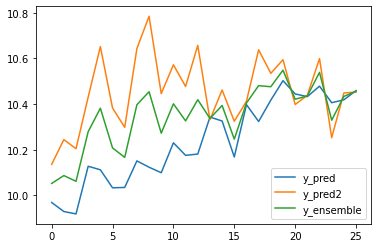

In [12]:
dataset, use_col = data_setting('shrimp','2016-07','2020-12')

dataset, sc = scaler(dataset)

window_size = 52
x, y, y_shape = split_xy(dataset, window_size, 26)
print(x.shape)
print(y.shape)


model = model_setting(LSTM,16)
model = model_train(x,y,model,250,16)

model2 = model_setting(GRU,64)
model2 = model_train(x,y,model2,250,64)


# model = load_models('흰다리새우LSTM')
# model2 = load_models('흰다리새우GRU')


y_pred = predict(model,sc)
y_pred2 = predict(model2,sc)
y_ensemble = ensemble(y_pred,y_pred2,5,5)


plt.plot(y_pred[:,-1],label='y_pred')
plt.plot(y_pred2[:,-1],label='y_pred2')
plt.plot(y_ensemble,label='y_ensemble')
plt.legend()
plt.show()

# save_csv(y_ensemble,"2021-01-04")

# save_model(model,'저장할이름')